In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_parquet("data/train.parquet")

In [28]:
domains = set(train_df["dagw_domain"])

vocabularies = {domain: set() for domain in domains}

for line in train_df.iterrows():
     vocabularies[line[1]["dagw_domain"]].update(line[1]["text"].split(" "))

def jaccard(setA: set, setB: set) -> float:
     if setA == setB: return 0
     return len(setA.intersection(setB)) / len(setA.union(setB))

jaccard_dict = {domain: dict() for domain in domains}
for domain_a in domains:
     for domain_b in domains:
          jaccard_dict[domain_a][domain_b] = jaccard(vocabularies[domain_a],vocabularies[domain_b])

Text(0.5, 1.0, 'jaccard simmilarity between vocabularies')

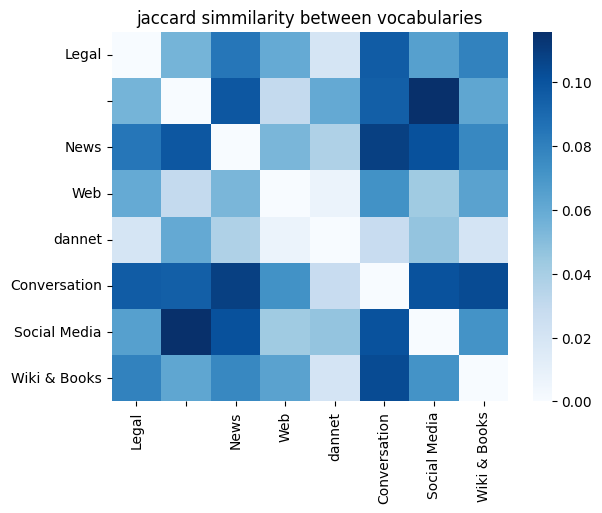

In [13]:
jaccard_df = pd.DataFrame(jaccard_dict)
sns.heatmap(jaccard_df, cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("jaccard simmilarity between vocabularies")

In [14]:
domains = set(train_df["dagw_domain"])

vocabularies = {domain: set() for domain in domains}

for line in train_df.iterrows():
     vocabularies[line[1]["dagw_domain"]].update(line[1]["text"].split(" "))

def jaccard(setA: set, setB: set) -> float:
     if setA == setB: return 0
     return len(setA.intersection(setB)) / len(setA.union(setB))

jaccard_dict = {domain: dict() for domain in domains}
for domain_a in domains:
     for domain_b in domains:
          jaccard_dict[domain_a][domain_b] = jaccard(vocabularies[domain_a],vocabularies[domain_b])
domains.remove(None)

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_df["text"])]

model = Doc2Vec(documents, vector_size=100, min_count=2, workers=4)

vectors = dict()
for domain in domains:
    vectors[domain] = model.infer_vector(train_df["text"][train_df["dagw_domain"] == domain]).reshape((1,-1))

simmilarity_dict = {domain: dict() for domain in domains}
for domain_a in domains:
     for domain_b in domains:
        simmilarity_dict[domain_a][domain_b] = cosine_similarity(vectors[domain_a], vectors[domain_b])[0][0]
        
print(simmilarity_dict)

{'Legal': {'Legal': 1.0, 'News': 0.60214424, 'Web': 0.77856225, 'dannet': 0.11003916, 'Conversation': 0.43333086, 'Social Media': -0.15016676, 'Wiki & Books': 0.37658346}, 'News': {'Legal': 0.60214424, 'News': 1.0, 'Web': 0.7499387, 'dannet': 0.051281728, 'Conversation': 0.90381193, 'Social Media': -0.0047276765, 'Wiki & Books': 0.5774838}, 'Web': {'Legal': 0.77856225, 'News': 0.7499387, 'Web': 1.0000001, 'dannet': 0.103075445, 'Conversation': 0.65690625, 'Social Media': -0.049722746, 'Wiki & Books': 0.5764296}, 'dannet': {'Legal': 0.11003916, 'News': 0.051281728, 'Web': 0.103075445, 'dannet': 0.9999999, 'Conversation': 0.10463038, 'Social Media': -0.03342299, 'Wiki & Books': 0.17996547}, 'Conversation': {'Legal': 0.43333086, 'News': 0.90381193, 'Web': 0.65690625, 'dannet': 0.10463038, 'Conversation': 1.0, 'Social Media': 0.082451455, 'Wiki & Books': 0.52673376}, 'Social Media': {'Legal': -0.15016676, 'News': -0.0047276765, 'Web': -0.049722746, 'dannet': -0.03342299, 'Conversation': 0.

Text(0.5, 1.0, 'Cosine similarity between doc2vec')

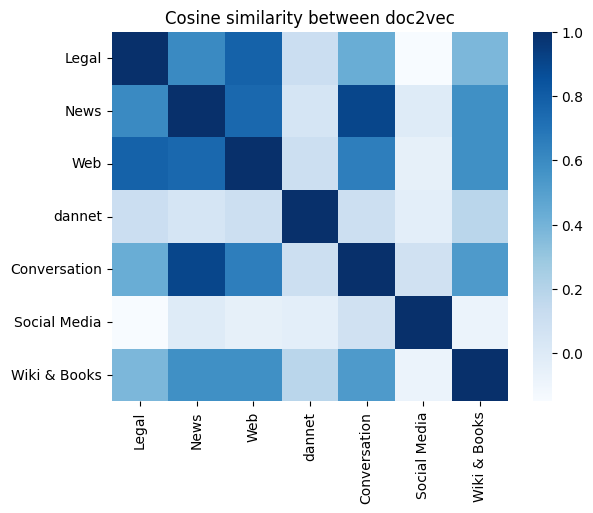

In [16]:
simmilarity_df = pd.DataFrame(simmilarity_dict)
sns.heatmap(simmilarity_df, cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Cosine similarity between doc2vec")

### Probability similarity between domains for entities

In [84]:
# lists containing unique entities and domains
entities = ['CARDINAL', 'DATE', 'EVENT', 'FACILITY', 'GPE', 'LANGUAGE', 
            'LAW', 'LOCATION', 'MONEY', 'NORP', 'ORDINAL', 'ORGANIZATION', 
            'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK OF ART']
domains = set(train_df["dagw_domain"])
domain_list = list(domains)


# creating dictionary of dictionaries containing the entity count for each entity type for each domain
count_dict = {domain : {ent: 0 for ent in entities} for domain in domain_list}

for _, row in train_df.iterrows():
    ents = row['ents']
    domain = row['dagw_domain']

    for ent in ents:
        label = ent['label']
        count_dict[domain][label] += 1


# creating a normalized vector of counts for each domain, i.e., a probability vector
perc_dict = {domain: [] for domain in count_dict.keys()}

for domain in count_dict.keys():
    ent_dict = count_dict[domain]
    for ent, count in ent_dict.items():
        perc_dict[domain].append(count)

for domain, count_list in perc_dict.items():
    total_count = np.sum(count_list)
    count_array = np.array([count_list])
    perc_dict[domain] = count_array / total_count

Text(0.5, 1.0, 'Entity distributions for each domain')

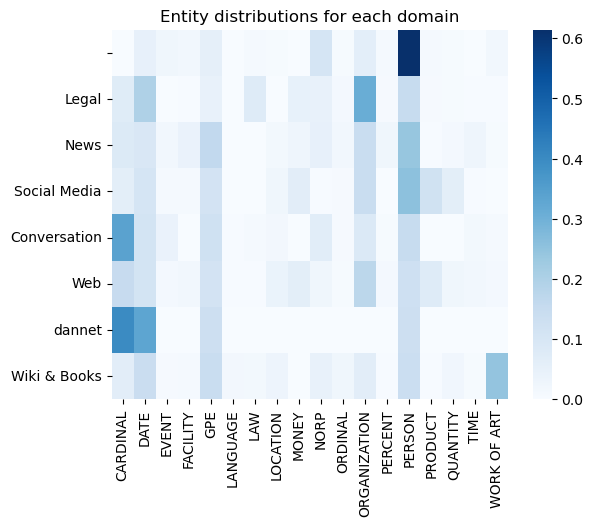

In [82]:
# heatmap showing the probability distribution over entities for each domain
for domain, ent_counts in count_dict.items():
    total_count = sum(ent_counts.values())
    for ent, count in ent_counts.items():
        count_dict[domain][ent] = count / total_count

# plotting a heatmap of the cosine similarity between each probability vector for each domain
ent_distribution_df = pd.DataFrame(count_dict).T
sns.heatmap(ent_distribution_df, cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Entity distributions for each domain")

Text(0.5, 1.0, 'Cosine similarity between entity distribution vectors')

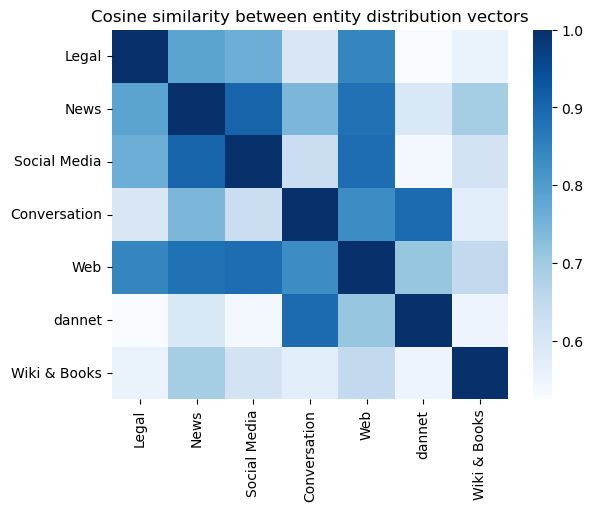

In [85]:
# creating a dictionary containing the cosine similarity of each probability vector between every pair of domains
domains = set(train_df["dagw_domain"])
domains.remove(None)
simmilarity_dict = {domain: dict() for domain in domains}
for domain_a in domains:
     vector_a = perc_dict[domain_a]
     for domain_b in domains:
        vector_b = perc_dict[domain_b]
        simmilarity_dict[domain_a][domain_b] = cosine_similarity(vector_a, vector_b)[0][0]

# plotting a heatmap of the cosine similarity between each probability vector for each domain
simmilarity_df = pd.DataFrame(simmilarity_dict)
sns.heatmap(simmilarity_df, cmap=sns.color_palette("Blues", as_cmap=True))
plt.title("Cosine similarity between entity distribution vectors")